In [32]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [33]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [34]:
df = pd.read_csv('TFR_CF4_components_bar', delimiter='|')
df = df.rename(columns=lambda x: x.strip())

df_TFR = df.set_index('PGC')
df_TFR = df_TFR.rename(columns={"Nest": "Nest_TFR"})
df_TFR = df_TFR.rename(columns={"PGC1": "PGC1_TFR"})
df_TFR = df_TFR.rename(columns={"Vcmb": "Vcmb_TFR"})
df_TFR = df_TFR.rename(columns={"DM_av": "DM_TFR"})
df_TFR = df_TFR.rename(columns={"eDM_av": "eDM_TFR"})

df_TFR = df_TFR[df_TFR["av_flag"]==0]

df_TFR.head()

,PGC1_TFR,Nest_TFR,Vcmb_TFR,Vmod,DM_TFR,eDM_TFR,av_flag,DM_cf4,eDM_cf4,cf4_flag,...,cf2_flag,DM_sfi,eDM_sfi,sfi_flag,DM_2mtf,eDM_2mtf,2mtf_flag,DM_flat,eDM_flat,flat_flag
PGC,,,,,,,,,,,,,,,,,,,,,
2,73150,200275,4726,4785,34.24,0.39,0,34.24,0.39,0,...,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0,0
4,120,202766,4109,4153,33.39,0.22,0,33.29,0.37,0,...,0,33.52,0.39,0,0.0,0.0,0,0.0,0.0,0
12,12,210177,6195,6296,35.03,0.39,0,35.03,0.39,0,...,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0,0
16,16,211419,5312,5386,34.70,0.37,0,34.70,0.37,0,...,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0,0
55,55,0,4454,4506,34.18,0.22,0,34.00,0.37,0,...,0,34.40,0.39,0,0.0,0.0,0,0.0,0.0,0


In [35]:
df = pd.read_csv('ALLcf3SNIa.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())

df['pgc'] = df['PGC']
df_ALLcf3SNIa = df.set_index('PGC')

df_ALLcf3SNIa["PGC1"] = df_ALLcf3SNIa.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.pgc, axis=1)


# df_ALLcf3SNIa['MINeDM'] = 0.10
# df_ALLcf3SNIa['min'] = df[["A","tmp"]].max(axis=1)


df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"Vcmb": "Vcmb_ALLcf3SNIa"})
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"PGC1": "PGC1_ALLcf3SNIa"})
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMav": "DM_ALLcf3SNIa"})
df_ALLcf3SNIa["eDM_ALLcf3SNIa"] = 0.15
df_ALLcf3SNIa["DM_ALLcf3SNIa"][df_ALLcf3SNIa["DM_ALLcf3SNIa"]==0] = np.nan
df_ALLcf3SNIa["eDM_ALLcf3SNIa"][df_ALLcf3SNIa["DM_ALLcf3SNIa"].isna()] = np.nan

#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_r"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_r"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMr": "DM_cf3SNIa_r"})
df_ALLcf3SNIa["eDMr"] = np.sqrt(df_ALLcf3SNIa["eDMr"]**2+0.15**2)
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"eDMr": "eDM_cf3SNIa_r"})
df_ALLcf3SNIa["DM_cf3SNIa_r"][df_ALLcf3SNIa["DM_cf3SNIa_r"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_r"][df_ALLcf3SNIa["DM_cf3SNIa_r"].isna()] = np.nan

#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_w"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_w"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMw": "DM_cf3SNIa_w"})
df_ALLcf3SNIa["eDM_cf3SNIa_w"] = 0.15
df_ALLcf3SNIa["DM_cf3SNIa_w"][df_ALLcf3SNIa["DM_cf3SNIa_w"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_w"][df_ALLcf3SNIa["DM_cf3SNIa_w"].isna()] = np.nan
#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_u"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_u"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMu": "DM_cf3SNIa_u"})
df_ALLcf3SNIa["eDMu"] = np.sqrt(df_ALLcf3SNIa["eDMu"]**2+0.15**2)
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"eDMu": "eDM_cf3SNIa_u"})
df_ALLcf3SNIa["DM_cf3SNIa_u"][df_ALLcf3SNIa["DM_cf3SNIa_u"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_u"][df_ALLcf3SNIa["DM_cf3SNIa_u"].isna()] = np.nan
#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_j"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_j"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMj": "DM_cf3SNIa_j"})
df_ALLcf3SNIa["eDMj"] = np.sqrt(df_ALLcf3SNIa["eDMj"]**2+0.15**2)
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"eDMj": "eDM_cf3SNIa_j"})
df_ALLcf3SNIa["DM_cf3SNIa_j"][df_ALLcf3SNIa["DM_cf3SNIa_j"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_j"][df_ALLcf3SNIa["DM_cf3SNIa_j"].isna()] = np.nan
#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_p"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_p"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMp": "DM_cf3SNIa_p"})
df_ALLcf3SNIa["eDMp"] = np.sqrt(df_ALLcf3SNIa["eDMp"]**2+0.15**2)
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"eDMp": "eDM_cf3SNIa_p"})
df_ALLcf3SNIa["DM_cf3SNIa_p"][df_ALLcf3SNIa["DM_cf3SNIa_p"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_p"][df_ALLcf3SNIa["DM_cf3SNIa_p"].isna()] = np.nan
#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_h"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_h"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMh": "DM_cf3SNIa_h"})
df_ALLcf3SNIa["eDM_cf3SNIa_h"] = 0.15
df_ALLcf3SNIa["DM_cf3SNIa_h"][df_ALLcf3SNIa["DM_cf3SNIa_h"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_h"][df_ALLcf3SNIa["DM_cf3SNIa_h"].isna()] = np.nan
#################
df_ALLcf3SNIa["Vcmb_cf3SNIa_f"] = df_ALLcf3SNIa["Vcmb_ALLcf3SNIa"]
df_ALLcf3SNIa["PGC1_cf3SNIa_f"] = df_ALLcf3SNIa["PGC1_ALLcf3SNIa"]
df_ALLcf3SNIa = df_ALLcf3SNIa.rename(columns={"DMf": "DM_cf3SNIa_f"})
df_ALLcf3SNIa["eDM_cf3SNIa_f"] = 0.15
df_ALLcf3SNIa["DM_cf3SNIa_f"][df_ALLcf3SNIa["DM_cf3SNIa_f"]==0] = np.nan
df_ALLcf3SNIa["eDM_cf3SNIa_f"][df_ALLcf3SNIa["DM_cf3SNIa_f"].isna()] = np.nan

# "ALLcf3SNIa", "cf3SNIa_w"
catalogs = ["cf3SNIa_r", "cf3SNIa_u", "cf3SNIa_j","cf3SNIa_p", "cf3SNIa_h","cf3SNIa_f", "cf3SNIa_w"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df_ALLcf3SNIa = df_ALLcf3SNIa[ss]

print(len(df_ALLcf3SNIa))

df_ALLcf3SNIa.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:28

389


/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PGC1_cf3SNIa_r,DM_cf3SNIa_r,eDM_cf3SNIa_r,Vcmb_cf3SNIa_r,PGC1_cf3SNIa_u,DM_cf3SNIa_u,eDM_cf3SNIa_u,Vcmb_cf3SNIa_u,PGC1_cf3SNIa_j,DM_cf3SNIa_j,...,eDM_cf3SNIa_h,Vcmb_cf3SNIa_h,PGC1_cf3SNIa_f,DM_cf3SNIa_f,eDM_cf3SNIa_f,Vcmb_cf3SNIa_f,PGC1_cf3SNIa_w,DM_cf3SNIa_w,eDM_cf3SNIa_w,Vcmb_cf3SNIa_w
PGC,,,,,,,,,,,,,,,,,,,,,
250,250,34.93,0.219317,6905,250,34.34,0.234307,6905,250,NaN,...,0.15,6905,250,NaN,NaN,6905,250,NaN,NaN,6905
282,282,35.95,0.258070,11001,282,NaN,NaN,11001,282,NaN,...,NaN,11001,282,NaN,NaN,11001,282,NaN,NaN,11001
415,415,34.97,0.226716,7183,415,34.44,0.242074,7183,415,NaN,...,0.15,7183,415,NaN,NaN,7183,415,NaN,NaN,7183
515,515,NaN,NaN,4897,515,33.70,0.258070,4897,515,NaN,...,0.15,4897,515,NaN,NaN,4897,515,NaN,NaN,4897
963,963,NaN,NaN,3607,963,32.64,0.317648,3607,963,32.87,...,NaN,3607,963,NaN,NaN,3607,963,NaN,NaN,3607


In [36]:
df = pd.read_csv('ScolnicSNIa3Tables.csv', delimiter='|')

df = df.rename(columns=lambda x: x.strip())
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)

df = df.set_index('PGC')



df = df.rename(columns={"Nest": "Nest_scolnic"})
df["Vcmb_scolnic"] = Vh2V3k(df["Glon"], df["Glat"], df["Vhel"])
df = df.rename(columns={"PGC1": "PGC1_scolnic"})
df["eDM_scolnic"] = df.apply(lambda x: 
                             x.eDMp if x["Tab"]==1 
                             else (x["eDM18"] if 
                            ["Tab"]==2 else x["eDM17"]) 
                            , axis=1)


df["eDM_scolnic"] = np.sqrt(df["eDM_scolnic"]**2+0.15**2)

df_scolnic = df.rename(columns={"DM": "DM_scolnic"})
df_scolnic["DM_scolnic"][df_scolnic["DM_scolnic"]==0] = np.nan
df_scolnic["eDM_scolnic"][df_scolnic["DM_scolnic"].isna()] = np.nan
df_scolnic.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SNIa,PGC1_scolnic,Nest_scolnic,Tab,DM_scolnic,DMp,eDMp,DM18,eDM18,DM17,eDM17,Vhel,Vsn,Glon,Glat,SGL,SGB,Vcmb_scolnic,eDM_scolnic
PGC,,,,,,,,,,,,,,,,,,,
250,2006sr,250,208532,1,35.061,35.061,0.133,35.057,0.102,35.046,0.079,7253,7147,108.8693,-38.3606,316.3211,17.6720,6905.301355,0.200472
282,2008hj,282,0,3,36.025,0.000,0.000,0.000,0.000,36.025,0.091,11360,11003,85.7160,-70.5385,282.0792,8.9703,11016.755644,0.175445
415,2003it,415,200542,1,35.150,35.150,0.140,35.147,0.108,35.149,0.089,7522,7582,110.6597,-34.3329,320.8087,17.8681,7183.381394,0.205183
963,1998dk,963,211877,1,33.339,33.339,0.191,33.350,0.168,33.366,0.114,3961,3625,102.8519,-62.1619,292.9641,9.5361,3606.990039,0.242860
1371,AT2016eoa,1351,200045,2,34.736,0.000,0.000,34.736,0.133,34.758,0.088,6227,6326,113.8635,-39.9082,316.3366,13.5013,5884.878602,0.173908


In [37]:
df = pd.read_csv('Scolnic2020.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)

df = df.set_index('PGC')

df = df.rename(columns={"Nest": "Nest_scol20"})
df = df.rename(columns={"Vcmb": "Vcmb_scol20"})
df = df.rename(columns={"PGC1": "PGC1_scol20"})
df = df.rename(columns={"eDM": "eDM_scol20"})

df["eDM_scol20"] = np.sqrt(df["eDM_scol20"]**2+0.15**2)

df_scol20 = df.rename(columns={"DM": "DM_scol20"})
df_scol20["DM_scol20"][df_scol20["DM_scol20"]==0] = np.nan
df_scol20["eDM_scol20"][df_scol20["DM_scol20"].isna()] = np.nan
df_scol20.head()

df_scol20.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,SNIa,PGC1_scol20,Nest_scol20,DM_scol20,eDM_scol20,Vrc3,Vhel,Vcmb_scol20,eV,Vpec,...,De,J2000,Glon,Glat,SGL,SGB,EBV,Ty,lgMass,N
PGC,,,,,,,,,,,,,,,,,,,,,
250,2006sr,250,208532,35.0397,0.246891,7260,7270,6916,3,240,...,23.196171,J000335.0+231203,108.8693,-38.3607,316.3211,17.6719,5.6,0.08,10.7951,1
282,2008hj,282,0,35.9417,0.237162,11360,11275,10921,45,132,...,-11.168750,J000401.5-111027,85.7160,-70.5384,282.0792,8.9703,1.3,0.02,9.9461,2
415,2003it,415,200542,35.1078,0.248483,7516,7513,7165,3,322,...,27.449444,J000548.4+272657,110.6598,-34.3328,320.8089,17.8681,3.3,0.05,10.4235,1
963,1998dk,963,211877,33.3500,0.279551,3953,3945,3589,3,47,...,-0.736360,J001431.9-004415,102.8518,-62.1619,292.9641,9.5362,5.2,0.03,9.4149,1
1371,AT2016eoa,1351,200045,34.7503,0.260108,6227,6323,5975,21,391,...,22.435440,J002122.5+222601,113.8635,-39.9080,316.3368,13.5013,-4.8,0.06,10.2163,1


In [38]:
df = pd.read_csv('CSP1Burns18.csv', delimiter='|')

df = df.rename(columns=lambda x: x.strip())
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

df = df.rename(columns={"Nest": "Nest_csp1"})
df = df.rename(columns={"PGC1": "PGC1_csp1"})

df["Vcmb_csp1"] = df["z3k"] * 299792.458

df = df.rename(columns={"muCV": "DM_csp1"})

df["emu"] = np.sqrt(df["emu"]**2+0.15**2)

df_csp1 = df.rename(columns={"emu": "eDM_csp1"})

df_csp1["DM_csp1"][df_csp1["DM_csp1"]==0] = np.nan
df_csp1["eDM_csp1"][df_csp1["DM_csp1"].isna()] = np.nan

df_csp1.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SNIa,PGC1_csp1,Nest_csp1,DM_csp1,eDM_csp1,zh,z3k,sBV,esBV,Dm15,...,eRv,covER,Q,RA,Dec,glon,glat,sgl,sgb,Vcmb_csp1
PGC,,,,,,,,,,,,,,,,,,,,,
282,2008hj,282,0,36.11,0.155242,0.0379,0.0367,1.010,0.031,0.964,...,1.0,-0.0072,0.97,1.0080,-11.1687,85.2573,-70.7713,281.8123,8.8821,11002.383209
1583,2007A,1583,210125,34.20,0.161555,0.0176,0.0165,1.012,0.032,0.954,...,0.3,-0.0053,0.97,6.3194,12.8868,113.0917,-49.4843,307.0303,10.4751,4946.575557
2332,2006ej,2331,202847,34.67,0.161555,0.0204,0.0193,0.829,0.035,1.368,...,1.1,-0.0102,0.97,9.7490,-9.0157,113.1135,-71.6864,286.6520,1.3636,5785.994439
2559,2006et,2559,201302,34.66,0.158114,0.0222,0.0212,1.093,0.031,0.887,...,0.3,-0.0026,0.95,10.6909,-23.5584,85.8379,-86.7274,272.0395,-3.7542,6355.600110
3444,2007nq,3342,200043,36.19,0.155242,0.0450,0.0439,0.745,0.030,1.491,...,1.2,-0.0037,0.94,14.3900,-1.3887,126.5363,-64.8731,294.6544,-1.1653,13160.888906


In [39]:
df = pd.read_csv('lossGanesh13.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

df = df.rename(columns={"Nest": "Nest_ganesh"})
df = df.rename(columns={"PGC1": "PGC1_ganesh"})

df["Vcmb_ganesh"] = df["z3k"] * 299792.458

df = df.rename(columns={"mu": "DM_ganesh"})
df["emu"] = np.sqrt(df["emu"]**2+0.15**2)

df_ganesh = df.rename(columns={"emu": "eDM_ganesh"})

df_ganesh["DM_ganesh"][df_ganesh["DM_ganesh"]==0] = np.nan
df_ganesh["eDM_ganesh"][df_ganesh["DM_ganesh"].isna()] = np.nan

df_ganesh.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,SNIa,PGC1_ganesh,Nest_ganesh,RA,Dec,z3k,B,eB,x1,ex1,c,ec,DM_ganesh,eDM_ganesh,Sample,Ref,Vcmb_ganesh
PGC,,,,,,,,,,,,,,,,,
250,SN 2006sr,250,208532,00 03 35.02,+23 11 46.2,0.023,16.123,0.030,-1.220,0.142,-0.020,0.029,35.070,0.226716,Low-z,5,6895.226534
465,SN 2000dg,616,200076,00 06 13.81,+08 53 17.5,0.037,16.989,0.068,-1.442,0.420,-0.057,0.045,36.021,0.236620,Low-z,2,11092.320946
515,SN 2002hw,515,210067,00 06 49.06,+08 37 48.5,0.016,16.646,0.038,-1.849,0.203,0.377,0.034,34.245,0.249201,Low-z,5,4796.679328
2332,SN 2006ej,2331,202847,00 38 59.77,-09 00 56.6,0.019,15.743,0.031,-1.583,0.116,-0.035,0.030,34.683,0.235847,Low-z,2,5696.056702
2559,SN 2006et,2559,201302,00 42 45.82,-23 33 30.4,0.021,15.950,0.034,0.812,0.170,0.110,0.030,34.781,0.232011,Low-z,5,6295.641618


In [40]:
how = 'outer'

df = df_ALLcf3SNIa.join(df_scol20, lsuffix='_l', rsuffix='_r', how=how)
df = df.join(df_scolnic, lsuffix='_l', rsuffix='_r', how=how)
df = df.join(df_csp1, lsuffix='_l1', rsuffix='_r1', how=how)
df = df.join(df_ganesh, lsuffix='_l2', rsuffix='_r2', how=how)

# catalogs = ["scol20"]

catalogs = ["scol20", "scolnic", "csp1", "ganesh"]
catalogs += ["cf3SNIa_r", "cf3SNIa_u", "cf3SNIa_j","cf3SNIa_p", "cf3SNIa_h","cf3SNIa_f"]#, "cf3SNIa_w"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]

print(len(df))

df.head()

944


,PGC1_scol20,DM_scol20,eDM_scol20,Vcmb_scol20,PGC1_scolnic,DM_scolnic,eDM_scolnic,Vcmb_scolnic,PGC1_csp1,DM_csp1,...,Vcmb_cf3SNIa_p,PGC1_cf3SNIa_h,DM_cf3SNIa_h,eDM_cf3SNIa_h,Vcmb_cf3SNIa_h,PGC1_cf3SNIa_f,DM_cf3SNIa_f,eDM_cf3SNIa_f,Vcmb_cf3SNIa_f,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
250,250.0,35.0397,0.246891,6916.0,250.0,35.061,0.200472,6905.301355,NaN,NaN,...,6905.0,250.0,34.35,0.15,6905.0,250.0,NaN,NaN,6905.0,250.0
282,282.0,35.9417,0.237162,10921.0,282.0,36.025,0.175445,11016.755644,282.0,36.11,...,11001.0,282.0,NaN,NaN,11001.0,282.0,NaN,NaN,11001.0,282.0
415,415.0,35.1078,0.248483,7165.0,415.0,35.150,0.205183,7183.381394,NaN,NaN,...,7183.0,415.0,34.49,0.15,7183.0,415.0,NaN,NaN,7183.0,415.0
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,616.0
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4897.0,515.0,33.68,0.15,4897.0,515.0,NaN,NaN,4897.0,515.0


In [41]:
ss = []

###   "scolnic", "csp1", "ganesh"
catals = ["csp1", "ganesh" ]
for cat in catals:
    ss += ["DM_"+cat]

df_ = df[ss].dropna()


delta = df_['DM_'+catals[0]] - df_['DM_'+catals[1]]

np.median(delta)

-0.03300000000000125

In [42]:
# for cat in catalogs:
#     df["eDM_"+cat] = 0.2


In [43]:
df.head()

,PGC1_scol20,DM_scol20,eDM_scol20,Vcmb_scol20,PGC1_scolnic,DM_scolnic,eDM_scolnic,Vcmb_scolnic,PGC1_csp1,DM_csp1,...,Vcmb_cf3SNIa_p,PGC1_cf3SNIa_h,DM_cf3SNIa_h,eDM_cf3SNIa_h,Vcmb_cf3SNIa_h,PGC1_cf3SNIa_f,DM_cf3SNIa_f,eDM_cf3SNIa_f,Vcmb_cf3SNIa_f,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
250,250.0,35.0397,0.246891,6916.0,250.0,35.061,0.200472,6905.301355,NaN,NaN,...,6905.0,250.0,34.35,0.15,6905.0,250.0,NaN,NaN,6905.0,250.0
282,282.0,35.9417,0.237162,10921.0,282.0,36.025,0.175445,11016.755644,282.0,36.11,...,11001.0,282.0,NaN,NaN,11001.0,282.0,NaN,NaN,11001.0,282.0
415,415.0,35.1078,0.248483,7165.0,415.0,35.150,0.205183,7183.381394,NaN,NaN,...,7183.0,415.0,34.49,0.15,7183.0,415.0,NaN,NaN,7183.0,415.0
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,616.0
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4897.0,515.0,33.68,0.15,4897.0,515.0,NaN,NaN,4897.0,515.0


In [44]:
d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)
dg.replace([0], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
# dg = df.groupby("pgc1").agg(["sum", "count"])
# dg.head()

In [46]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [47]:
t1 =  datetime.now()

print GfastChi2(dg_, theta=range(len(catalogs)))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

202839.35753473005
Execution time:
0:00:00.064576


In [48]:
dg.head()

,N_scol20,DMg_scol20,eDMg_scol20,N_scolnic,DMg_scolnic,eDMg_scolnic,N_csp1,DMg_csp1,eDMg_csp1,N_ganesh,...,eDMg_cf3SNIa_j,N_cf3SNIa_p,DMg_cf3SNIa_p,eDMg_cf3SNIa_p,N_cf3SNIa_h,DMg_cf3SNIa_h,eDMg_cf3SNIa_h,N_cf3SNIa_f,DMg_cf3SNIa_f,eDMg_cf3SNIa_f
,,,,,,,,,,,...,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,,,,,,,
250,1.0,35.0397,0.246891,1.0,35.061,0.200472,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,34.35,0.15,NaN,NaN,NaN
282,1.0,35.9417,0.237162,1.0,36.025,0.175445,1.0,36.11,0.155242,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415,1.0,35.1078,0.248483,1.0,35.150,0.205183,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,34.49,0.15,NaN,NaN,NaN
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,33.68,0.15,NaN,NaN,NaN
616,1.0,36.0991,0.245226,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df

,PGC1_scol20,DM_scol20,eDM_scol20,Vcmb_scol20,PGC1_scolnic,DM_scolnic,eDM_scolnic,Vcmb_scolnic,PGC1_csp1,DM_csp1,...,w_cf3SNIa_u,xw_cf3SNIa_u,w_cf3SNIa_j,xw_cf3SNIa_j,w_cf3SNIa_p,xw_cf3SNIa_p,w_cf3SNIa_h,xw_cf3SNIa_h,w_cf3SNIa_f,xw_cf3SNIa_f
PGC,,,,,,,,,,,,,,,,,,,,,
250,250.0,35.0397,0.246891,6916.0,250.0,35.061,0.200472,6905.301355,NaN,NaN,...,18.214936,625.500911,NaN,NaN,NaN,NaN,44.444444,1526.666667,NaN,NaN
282,282.0,35.9417,0.237162,10921.0,282.0,36.025,0.175445,11016.755644,282.0,36.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415,415.0,35.1078,0.248483,7165.0,415.0,35.150,0.205183,7183.381394,NaN,NaN,...,17.064846,587.713311,NaN,NaN,NaN,NaN,44.444444,1532.888889,NaN,NaN
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.015015,506.006006,NaN,NaN,NaN,NaN,44.444444,1496.888889,NaN,NaN
963,963.0,33.3500,0.279551,3589.0,963.0,33.339,0.242860,3606.990039,NaN,NaN,...,9.910803,323.488603,14.104372,463.610719,40.000000,1309.600000,NaN,NaN,NaN,NaN
1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.752969,770.308789,27.100271,884.281843,NaN,NaN,NaN,NaN
1371,1351.0,34.7503,0.260108,5975.0,1351.0,34.736,0.173908,5884.878602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1583,1583.0,34.4427,0.256526,4935.0,1583.0,34.537,0.212840,4834.157291,1583.0,34.20,...,11.764706,393.176471,22.222222,736.444444,38.314176,1270.114943,NaN,NaN,NaN,NaN


In [50]:
len(dg_)

859

In [51]:
dg_.head()

,DMg_scol20,DMg_scolnic,DMg_csp1,DMg_ganesh,DMg_cf3SNIa_r,DMg_cf3SNIa_u,DMg_cf3SNIa_j,DMg_cf3SNIa_p,DMg_cf3SNIa_h,DMg_cf3SNIa_f,...,gxi2_scol20,gxi2_scolnic,gxi2_csp1,gxi2_ganesh,gxi2_cf3SNIa_r,gxi2_cf3SNIa_u,gxi2_cf3SNIa_j,gxi2_cf3SNIa_p,gxi2_cf3SNIa_h,gxi2_cf3SNIa_f
,,,,,,,,,,,...,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,,,,,,,
250,35.0397,35.061,NaN,35.070,34.93,34.34,NaN,NaN,34.35,NaN,...,228.946939,181.083314,NaN,14.264228,0.049508,2.070373,NaN,NaN,385.324316,NaN
282,35.9417,36.025,36.11,NaN,35.95,NaN,NaN,NaN,NaN,NaN,...,45.926324,10.607670,5.587475,NaN,67.976884,NaN,NaN,NaN,NaN,NaN
415,35.1078,35.150,NaN,NaN,34.97,34.44,NaN,NaN,34.49,NaN,...,246.114455,191.881167,NaN,NaN,1.398531,0.490575,NaN,NaN,339.292128,NaN
515,NaN,NaN,NaN,34.245,NaN,33.70,NaN,NaN,33.68,NaN,...,NaN,NaN,NaN,111.458735,NaN,26.071923,NaN,NaN,66.134063,NaN
616,36.0991,NaN,NaN,36.021,NaN,NaN,NaN,NaN,NaN,NaN,...,25.687587,NaN,NaN,23.353472,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
len(df)

944

In [53]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

Execution time:
8:52:30.434316


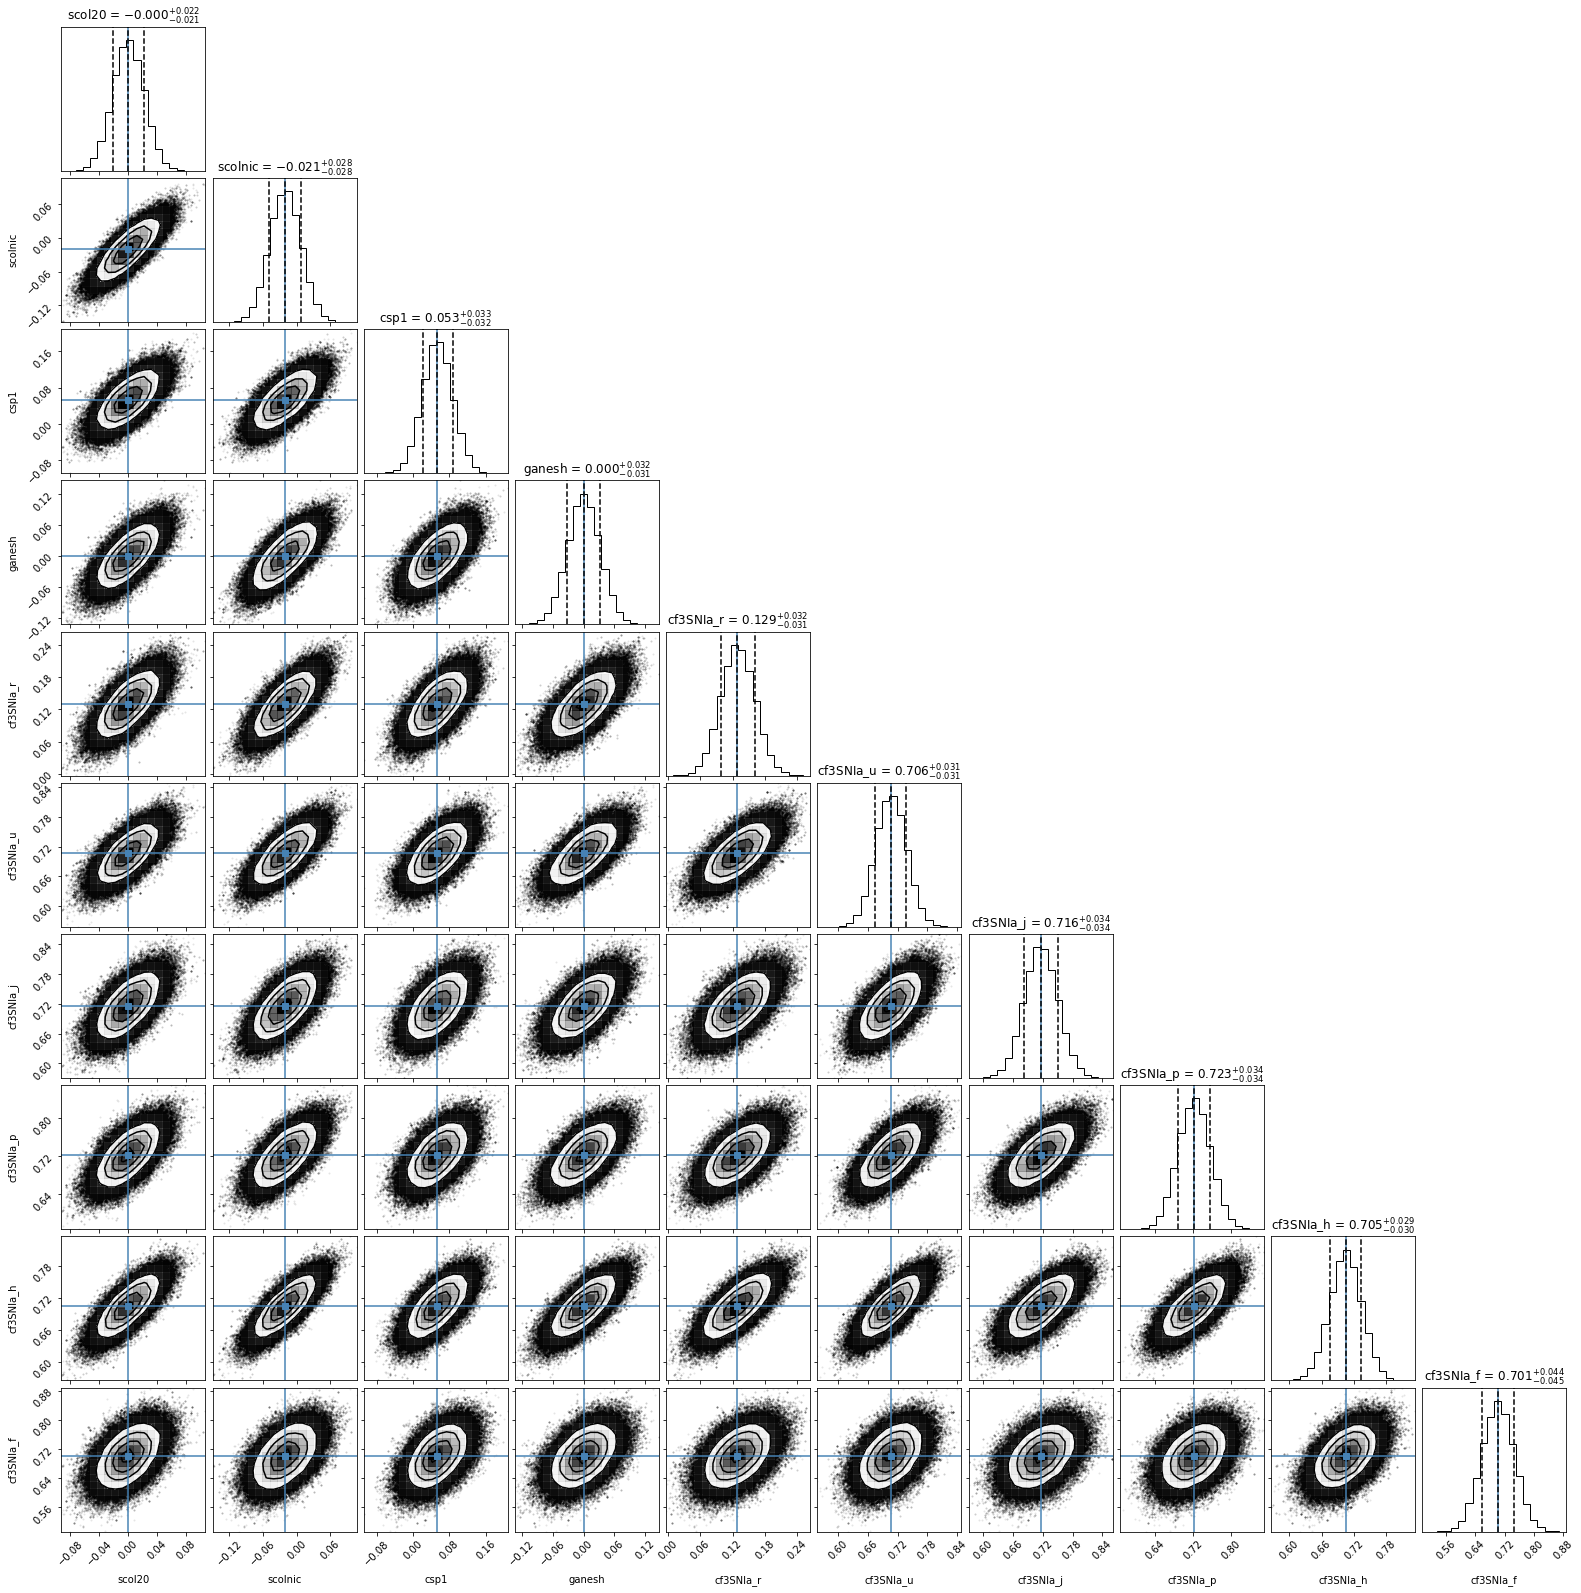

In [54]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 128

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [66]:
npzName = "SNIa_groups.npz"
np.savez(npzName, samples)
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

('npz attributes: ', ['arr_0'])


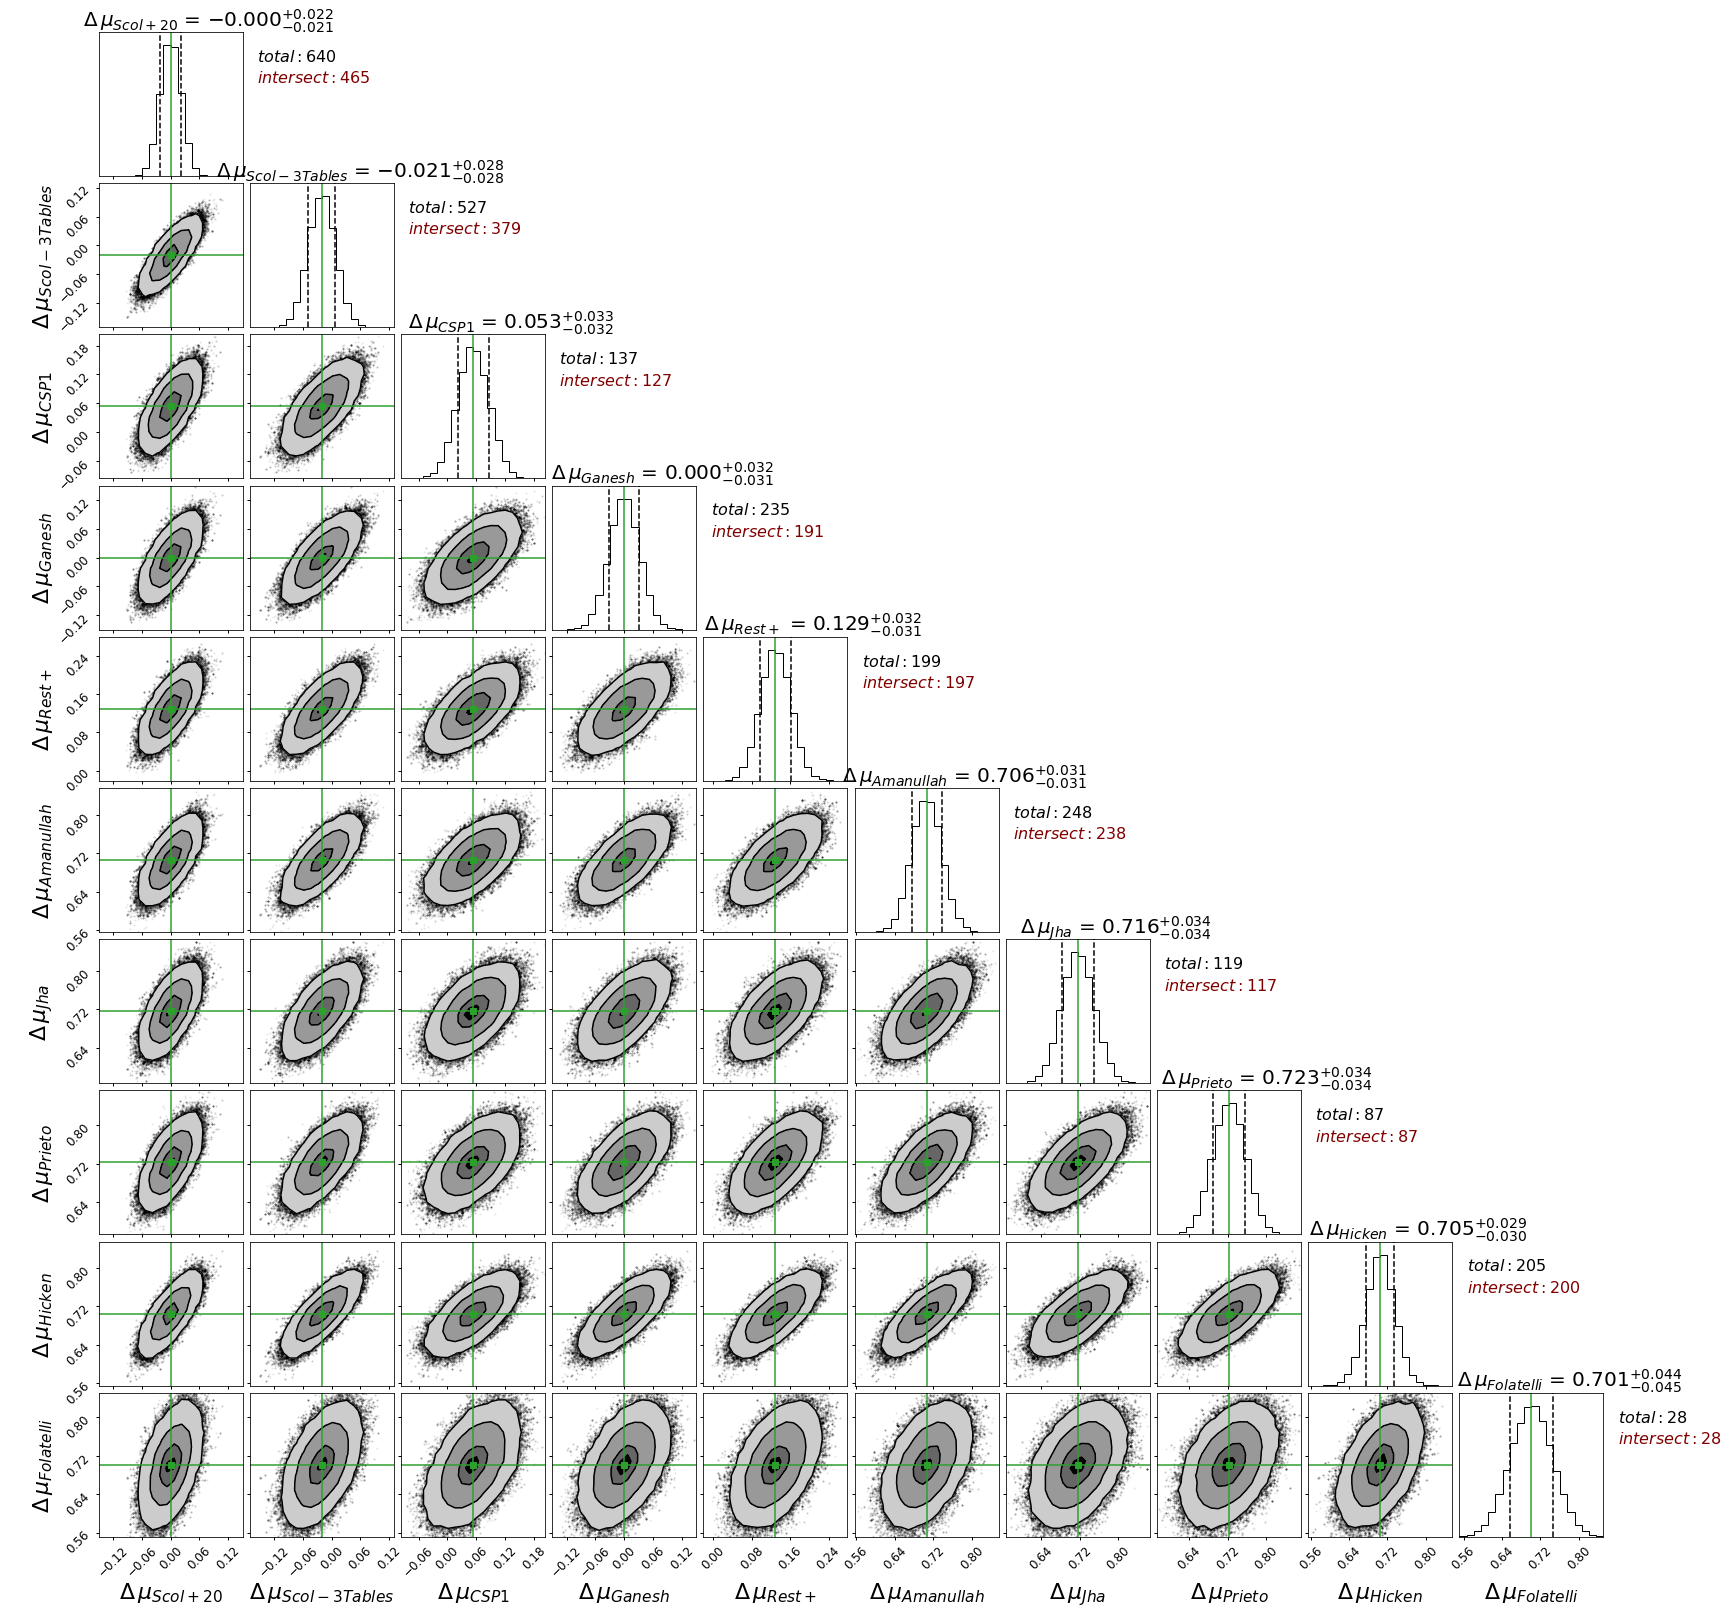

In [64]:
theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]

labels = ['            '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in ["Scol+20", "Scol-3Tables", "CSP1", "Ganesh", "Rest+", "Amanullah", "Jha", "Prieto", "Hicken", "Folatelli"]] # catalogs[1:]]

fig = corner.corner(NPZsamples, labels=labels, 
                    truths=truths, truth_color='#2ca02c',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 20}, 
                    title_fmt=".3f",
                    range=[(t-0.15,t+0.15) for t in truths]
                   )

m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()       
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

